In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from agent import Agent, Env
from pfilter import ParticleFilter
from scipy.special import logsumexp

In [2]:
im_x = 80
im_y = 80

seqlen = 300

n_agents = 6

In [3]:
env = Env(*[Agent(im_x, im_y) for _ in range(n_agents)])

In [4]:
# env.agents[0].dim = env.agents[1].dim
# env.agents[0].pos = env.agents[1].pos
# env.agents[0].vel = env.agents[1].vel

In [5]:
aa = env.step()

In [6]:
aa

[array([ 15.67166489,  64.93121625,  23.79391159,  71.29518734]),
 array([  5.21732765,  11.07106876,  10.58975542,  17.73228935]),
 array([ 66.71152673,  21.71162428,  74.04050095,  28.19805296]),
 array([ 52.77660207,  76.06496091,  60.89134086,  79.7081087 ])]

In [7]:
def all_permutations(l):
    if l == 0:
        return [[0]]
    else:
        prev = all_permutations(l-1)
        ans = []
        for i in range(l+1):
            for perm in prev:
                tmp = perm[:]
                tmp.insert(i, l)
                ans.append(tmp)
        return ans

In [8]:
def evol_model(particles):
    particles = particles.copy()
    
    xy, wh = particles[:,:2], particles[:,2:4]
    vel = particles[:,4:]
    
    vel += np.random.normal(size=vel.shape)/12
    vel = np.clip(vel, -1, 1)
    
    xy += vel
    
    wh += np.random.normal(size=wh.shape)/40
    wh = np.clip(wh, 1, 30)
    
    xy = np.clip(xy, 0, np.array([im_x, im_y], dtype='float64') - wh)
    
    new_particles = np.concatenate([xy, wh, vel], axis=-1)
    return new_particles

def observe_model(particles, observe, beta=None):
    xy, wh = particles[:,:2], particles[:,2:4]
    
    xyxy = np.concatenate([xy, xy + wh], axis=-1)
    
    whs = np.stack([wh,wh], axis=-1).reshape((-1,4))
    #whs = np.array([10.]*4)
    
    ds = []
    for obs in observe:
        logd = - (xyxy - obs)**2/(2*(whs/12)**2) - np.log(np.sqrt(2*np.pi)*whs/12)
        logd = np.clip(logd, -10000, 10000)
        logd = np.sum(logd, axis=-1)
        ds.append(logd)
    
    
    ds = np.array(ds)

    if beta is not None:
        beta = np.array(beta)
        tmp = logsumexp(ds, b=beta[:,np.newaxis], axis=0)
        #print(beta)
        #print(tmp)
        if np.max(beta) < 1e-5:
            return 0
        else:
            return tmp
    else:
        return ds

In [9]:
filters = []
aa_ = env.step(see_all=True)
for i in range(n_agents):
    filt = ParticleFilter(1000, 4 + 2, evol_model, observe_model, resample_2entropy=0.8)
    aa = aa_[i]
    filt.particles[:, :2] = aa[:2] + np.random.normal(size=filt.particles[:, :2].shape)*3
    filt.particles[:, 2:4] = np.clip(aa[2:4] - aa[:2] + np.random.normal(size=filt.particles[:, 2:4].shape)*3, 1, 100)
    filters.append(filt)

In [10]:
observe = []
true = []
for _ in range(seqlen):
    observe.append(env.step())
    true.append([agent.pos for agent in env.agents])
    
observe = np.array(observe)
true = np.array(true)

In [11]:
agent = env.agents[0]

In [12]:
agent.w, agent.h

(8, 8)

In [13]:
# ao = list(observe)
# ao = iter(ao)

In [14]:
filtrated = [[]]

for obs in observe:
#obs = next(ao)
    betamat = np.zeros([len(filters), len(obs)], dtype='float64')

    for j, oo in enumerate(obs):
        for i, filt in enumerate(filters):
            ds = observe_model(filt.particles, [oo])[0] + filt.logweights
            #print('logweights {} {}: {}'.format(i, j, ds))
            betamat[i, j] = np.mean(np.exp(ds))

    #print(betamat)

    betaij = np.zeros_like(betamat)
    for perm in all_permutations(len(filters) - 1):
        for k, j in enumerate(perm[:len(obs)]):
            betaij[j, k] += np.prod(np.diag(betamat[perm,:][:len(obs)]))

    betaij /= np.sum(betaij)
    #print(betaij)

    for i, filt in enumerate(filters):
        part, w = filt.step(obs, betaij[i,:])
        ix = np.random.choice(np.arange(len(part)), size=len(part), p=w)
        filtrated[-1].append(part[ix])
        #print('after update {}'.format(filt.logweights))
    filtrated.append([])

In [15]:
betaij

array([[  2.00000000e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   2.00000000e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   2.00000000e-01,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e-01,   0.00000000e+00],
       [  1.54819318e-23,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e-01]])

In [16]:
filtrated = np.array(filtrated[:-1])

In [17]:
filtrated.shape

(300, 6, 1000, 6)

In [18]:
filtrated = filtrated.transpose([0,2,1,3])

In [19]:
fmean = filtrated.mean(axis=1)

In [20]:
fmean.shape

(300, 6, 6)

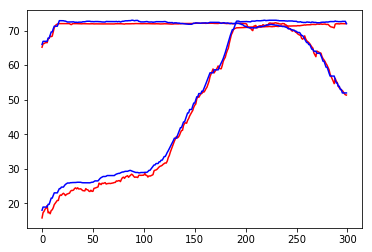

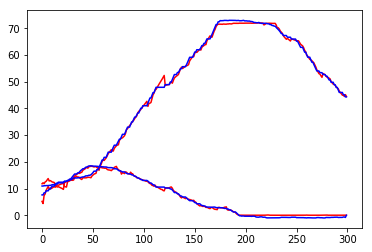

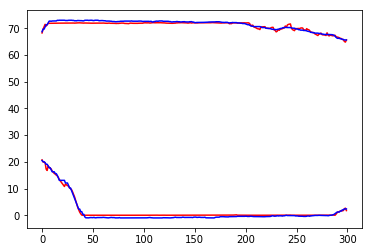

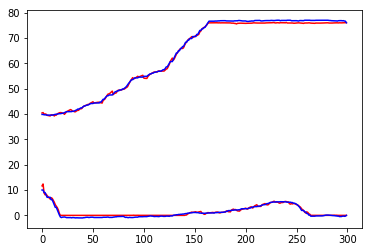

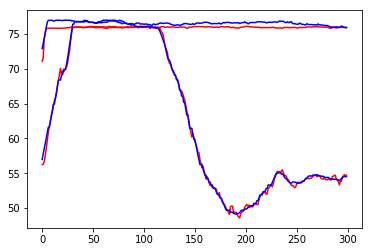

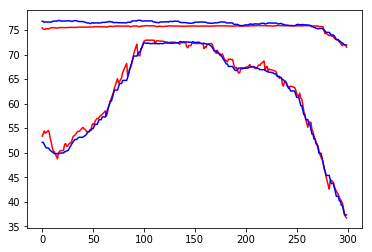




Object Dims:


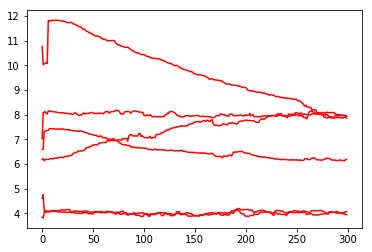

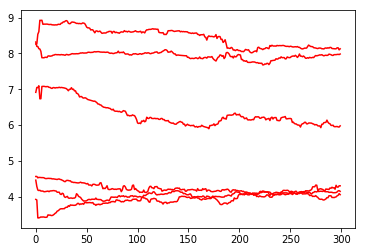

In [21]:
for i in range(n_agents):
    plt.plot(range(seqlen), fmean[:,i,:2], c='r')
    plt.plot(range(seqlen), true[:,i], c='b')
    plt.show()

print('\n\n\nObject Dims:')
plt.plot(range(seqlen), fmean[:,:,2], c='r')
plt.show()

plt.plot(range(seqlen), fmean[:,:,3], c='r')
plt.show()